# EC5303 Team Project: BTC & ETH Dependence and Regression
Full pipeline: load Kaggle data, clean, compute returns, run distribution tests, fit copulas, and estimate regressions as specified in README.


In [ ]:
# Run once in a fresh environment to install all dependencies
# !pip install -r requirements.txt

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path
from scipy import stats
from statsmodels.distributions.empirical_distribution import ECDF
import statsmodels.api as sm
import kagglehub
import pyvinecopulib as pv

sns.set_theme(style="whitegrid")
pd.set_option("display.float_format", lambda x: f"{x:,.6f}")

/opt/miniconda3/envs/kol-rl-agent/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Section A — Data Loading and Cleaning
- Uses `kagglehub.dataset_load` to retrieve BTC and ETH price history (Kaggle dataset `sudalairajkumar/cryptocurrencypricehistory`).
- Cleans columns, converts dates, sorts ascending, and drops duplicates.
- Computes daily log returns and merges into `df_ret` with `btc_ret` and `eth_ret`.


In [3]:
DATASET_ID = "sudalairajkumar/cryptocurrencypricehistory"
BTC_FILE = "coin_Bitcoin.csv"
ETH_FILE = "coin_Ethereum.csv"

def load_kaggle_csv(dataset_id: str, filename: str) -> pd.DataFrame:
    """Download dataset locally and read a specific CSV file."""
    dataset_dir = kagglehub.dataset_download(dataset_id)
    csv_path = Path(dataset_dir) / filename
    return pd.read_csv(csv_path)

df_btc_raw = load_kaggle_csv(DATASET_ID, BTC_FILE)
df_eth_raw = load_kaggle_csv(DATASET_ID, ETH_FILE)

display(df_btc_raw.head())
display(df_eth_raw.head())


,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap
0,1,Bitcoin,BTC,2013-04-29 23:59:59,147.488007,134.000000,134.444000,144.539993,0.000000,"1,603,768,864.500000"
1,2,Bitcoin,BTC,2013-04-30 23:59:59,146.929993,134.050003,144.000000,139.000000,0.000000,"1,542,813,125.000000"
2,3,Bitcoin,BTC,2013-05-01 23:59:59,139.889999,107.720001,139.000000,116.989998,0.000000,"1,298,954,593.750000"
3,4,Bitcoin,BTC,2013-05-02 23:59:59,125.599998,92.281898,116.379997,105.209999,0.000000,"1,168,517,495.250000"
4,5,Bitcoin,BTC,2013-05-03 23:59:59,108.127998,79.099998,106.250000,97.750000,0.000000,"1,085,995,168.750000"


,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap
0,1,Ethereum,ETH,2015-08-08 23:59:59,2.798810,0.714725,2.793760,0.753325,"674,188.000000","45,486,894.240800"
1,2,Ethereum,ETH,2015-08-09 23:59:59,0.879810,0.629191,0.706136,0.701897,"532,170.000000","42,399,573.499100"
2,3,Ethereum,ETH,2015-08-10 23:59:59,0.729854,0.636546,0.713989,0.708448,"405,283.000000","42,818,364.394500"
3,4,Ethereum,ETH,2015-08-11 23:59:59,1.131410,0.663235,0.708087,1.067860,"1,463,100.000000","64,569,288.432800"
4,5,Ethereum,ETH,2015-08-12 23:59:59,1.289940,0.883608,1.058750,1.217440,"2,150,620.000000","73,645,010.986300"


In [4]:
KEEP_COLS = ["Date", "Open", "High", "Low", "Close", "Volume", "Marketcap"]

def clean_crypto_df(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["Date"] = pd.to_datetime(df["Date"])
    df = df.sort_values("Date").drop_duplicates(subset="Date")
    df = df.drop(columns=[c for c in ["SNo", "Name", "Symbol"] if c in df.columns], errors="ignore")
    cols = [c for c in KEEP_COLS if c in df.columns]
    return df[cols]

df_btc = clean_crypto_df(df_btc_raw)
df_eth = clean_crypto_df(df_eth_raw)

df_btc["btc_ret"] = np.log(df_btc["Close"]).diff()
df_eth["eth_ret"] = np.log(df_eth["Close"]).diff()

df_ret = (
    df_btc[["Date", "btc_ret", "Volume"]]
    .merge(df_eth[["Date", "eth_ret"]], on="Date", how="inner")
    .dropna(subset=["btc_ret", "eth_ret"])
)
df_ret["vol_btc"] = np.log(df_ret["Volume"])

display(df_ret.head())

,Date,btc_ret,Volume,eth_ret,vol_btc
1,2015-08-09 23:59:59,0.015534,"23,789,600.000000",-0.070710,16.984759
2,2015-08-10 23:59:59,-0.002315,"20,979,400.000000",0.009290,16.859052
3,2015-08-11 23:59:59,0.022123,"25,433,900.000000",0.410335,17.051593
4,2015-08-12 23:59:59,-0.014942,"26,815,400.000000",0.131094,17.104487
5,2015-08-13 23:59:59,-0.008657,"27,685,500.000000",0.406292,17.136419


### Basic date quality checks
Verify duplicates and missing calendar days after cleaning BTC/ETH data.


In [5]:
def summarize_calendar_coverage(df: pd.DataFrame, label: str):
    dates = pd.to_datetime(df['Date'])
    duplicates = dates[dates.duplicated()]
    full_range = pd.date_range(dates.min(), dates.max(), freq='D')
    missing = full_range.difference(dates.drop_duplicates())

    print(f"{label}: rows={len(df)}, unique_dates={dates.nunique()}")
    print(f"  duplicate_dates: {len(duplicates)}")
    if len(duplicates) > 0:
        print(f"  sample duplicate dates: {[d.date() for d in duplicates.unique()[:5]]}")
    print(
        f"  missing calendar days between {dates.min().date()} and {dates.max().date()}: {len(missing)}"
    )
    if len(missing) > 0:
        print(f"  sample missing dates: {[d.date() for d in missing[:5]]}")
    print('-' * 60)

summarize_calendar_coverage(df_btc, 'BTC')
summarize_calendar_coverage(df_eth, 'ETH')


BTC: rows=2991, unique_dates=2991
  duplicate_dates: 0
  missing calendar days between 2013-04-29 and 2021-07-06: 0
------------------------------------------------------------
ETH: rows=2160, unique_dates=2160
  duplicate_dates: 0
  missing calendar days between 2015-08-08 and 2021-07-06: 0
------------------------------------------------------------


## Section B — Session 1: Distribution & Copula Analysis
All computations below use `btc_ret` and `eth_ret` as required.


In [123]:
def descriptive_stats(series: pd.Series) -> pd.Series:
    return pd.Series({
        "mean": series.mean(),
        "variance": series.var(ddof=1),
        "std": series.std(ddof=1),
        "skewness": series.skew(),
        "kurtosis": series.kurtosis(),
    })

desc = pd.concat(
    {
        "btc_ret": descriptive_stats(df_ret["btc_ret"]),
        "eth_ret": descriptive_stats(df_ret["eth_ret"]),
    },
    axis=1,
)
cov = df_ret["btc_ret"].cov(df_ret["eth_ret"])
corr = df_ret["btc_ret"].corr(df_ret["eth_ret"])

display(desc)
print(f"Covariance: {cov:.6f}")
print(f"Correlation: {corr:.6f}")

,btc_ret,eth_ret
mean,0.002259,0.003721
variance,0.001608,0.003856
std,0.040103,0.062099
skewness,-0.821522,0.005249
kurtosis,11.912273,7.667930


Covariance: 0.001356
Correlation: 0.544485


In [124]:
def normality_tests(series: pd.Series, label: str):
    mu, sigma = series.mean(), series.std(ddof=1)
    shapiro_stat, shapiro_p = stats.shapiro(series)
    ks_stat, ks_p = stats.kstest(series, "norm", args=(mu, sigma))
    jb_stat, jb_p = stats.jarque_bera(series)
    return {
        "Series": label,
        "Shapiro_W": shapiro_stat,
        "Shapiro_p": shapiro_p,
        "KS_stat": ks_stat,
        "KS_p": ks_p,
        "JB_stat": jb_stat,
        "JB_p": jb_p,
    }

tests = pd.DataFrame([
    normality_tests(df_ret["btc_ret"], "btc_ret"),
    normality_tests(df_ret["eth_ret"], "eth_ret"),
])
display(tests)

,Series,Shapiro_W,Shapiro_p,KS_stat,KS_p,JB_stat,JB_p
0,btc_ret,0.898178,0.000000,0.113167,0.000000,"12,942.845177",0.000000
1,eth_ret,0.912023,0.000000,0.092244,0.000000,"5,261.026821",0.000000


d:\miniconda\envs\ec5303\Lib\site-packages\statsmodels\graphics\gofplots.py:1041: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.2980392156862745, 0.4470588235294118, 0.6901960784313725, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


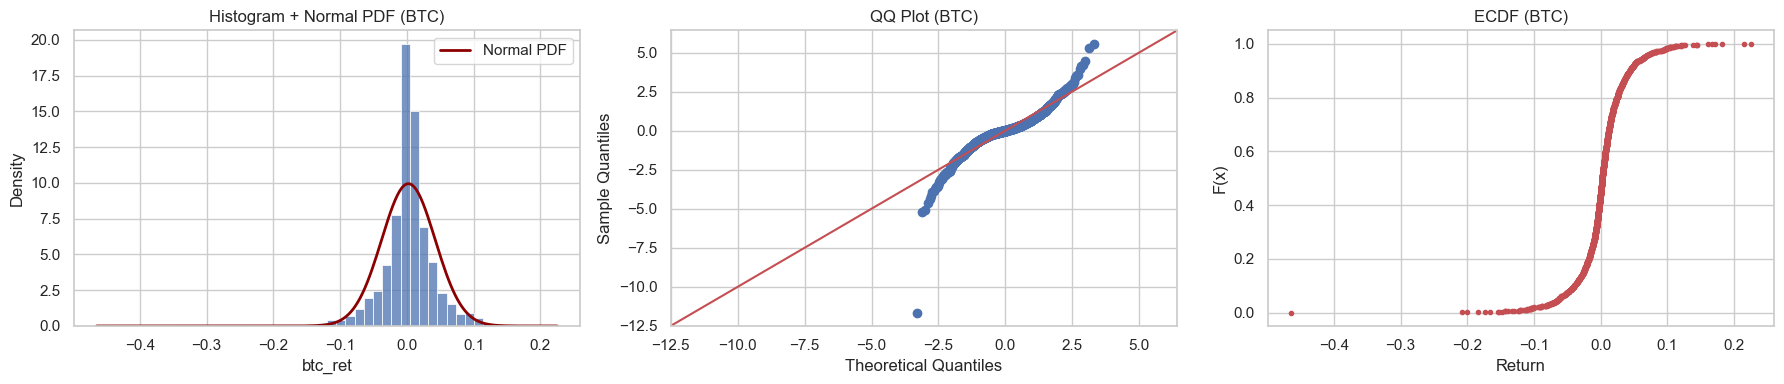

d:\miniconda\envs\ec5303\Lib\site-packages\statsmodels\graphics\gofplots.py:1041: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.2980392156862745, 0.4470588235294118, 0.6901960784313725, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


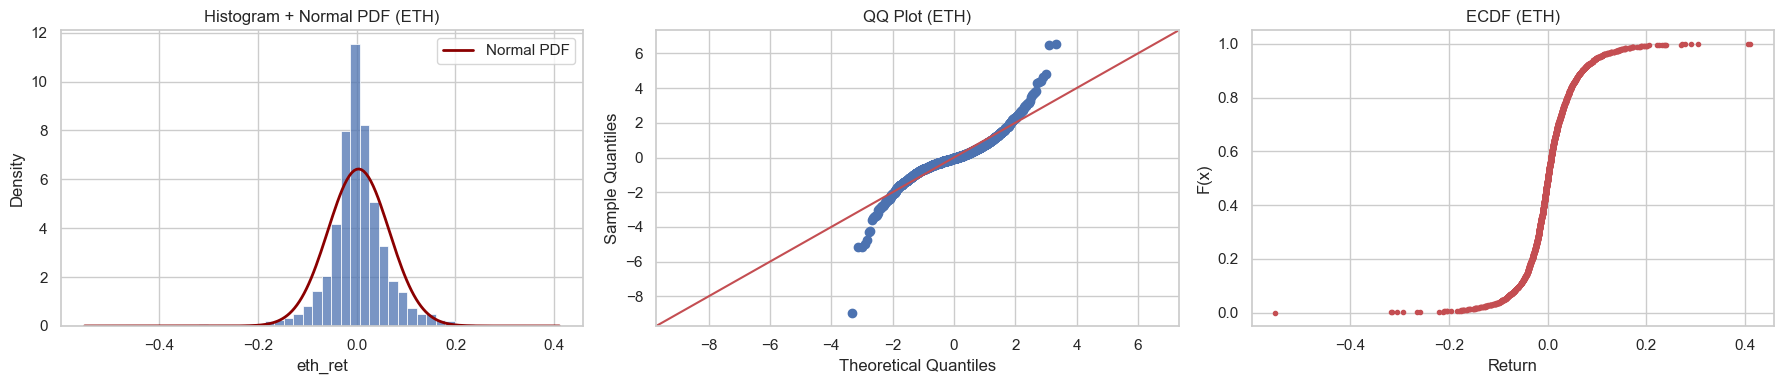

In [125]:
def plot_distribution(series: pd.Series, title: str):
    mu, sigma = series.mean(), series.std(ddof=1)
    x = np.linspace(series.min(), series.max(), 200)
    normal_pdf = stats.norm.pdf(x, mu, sigma)

    fig, axes = plt.subplots(1, 3, figsize=(18, 4))
    sns.histplot(series, bins=50, stat="density", kde=False, ax=axes[0], color="#4C72B0")
    axes[0].plot(x, normal_pdf, color="darkred", lw=2, label="Normal PDF")
    axes[0].set_title(f"Histogram + Normal PDF ({title})")
    axes[0].legend()

    sm.ProbPlot(series, fit=True).qqplot(line="45", ax=axes[1], color="#55A868")
    axes[1].set_title(f"QQ Plot ({title})")

    ecdf = ECDF(series)
    axes[2].plot(ecdf.x, ecdf.y, marker=".", linestyle="none", color="#C44E52")
    axes[2].set_title(f"ECDF ({title})")
    axes[2].set_xlabel("Return")
    axes[2].set_ylabel("F(x)")
    plt.tight_layout()
    plt.show()

plot_distribution(df_ret["btc_ret"], "BTC")
plot_distribution(df_ret["eth_ret"], "ETH")

### Moment Generating Function (MGF)
Approximate MGF for t ∈ [-1, 1]: M_X(t) = E[exp(tX)].


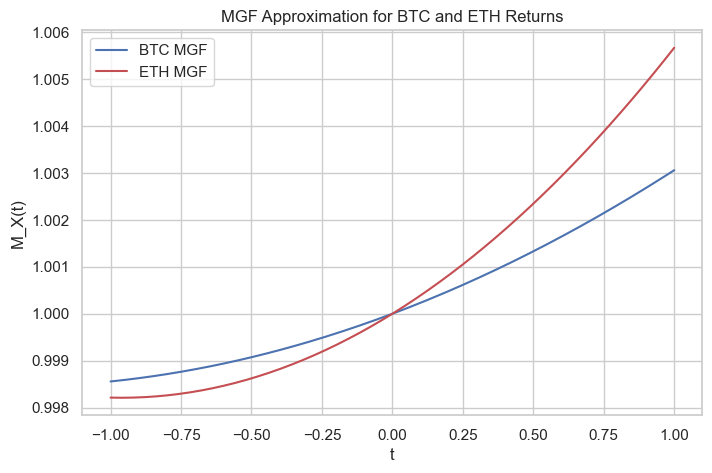

In [126]:
def mgf_curve(series: pd.Series, t_values: np.ndarray) -> np.ndarray:
    return np.array([np.exp(t * series).mean() for t in t_values])

t_grid = np.linspace(-1, 1, 200)
mgf_btc = mgf_curve(df_ret["btc_ret"], t_grid)
mgf_eth = mgf_curve(df_ret["eth_ret"], t_grid)

plt.figure(figsize=(8, 5))
plt.plot(t_grid, mgf_btc, label="BTC MGF", color="#4C72B0")
plt.plot(t_grid, mgf_eth, label="ETH MGF", color="#C44E52")
plt.xlabel("t")
plt.ylabel("M_X(t)")
plt.title("MGF Approximation for BTC and ETH Returns")
plt.legend()
plt.grid(True)
plt.show()

### Probability Integral Transform (PIT)
Empirical CDFs F̂_BTC and F̂_ETH applied to returns to get u_btc and v_eth in (0, 1).


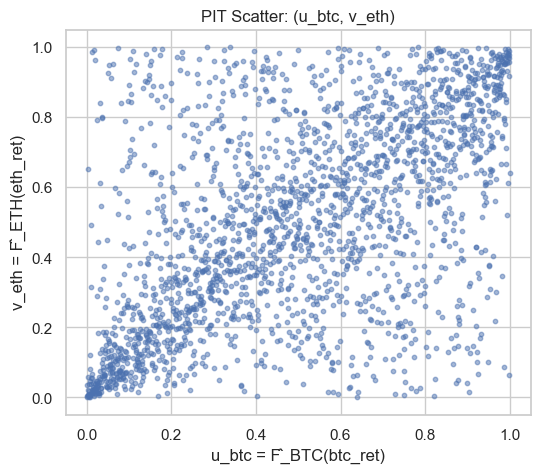

In [127]:
ecdf_btc = ECDF(df_ret["btc_ret"])
ecdf_eth = ECDF(df_ret["eth_ret"])

df_ret["u_btc"] = ecdf_btc(df_ret["btc_ret"])
df_ret["v_eth"] = ecdf_eth(df_ret["eth_ret"])
df_ret[["u_btc", "v_eth"]] = df_ret[["u_btc", "v_eth"]].clip(1e-6, 1 - 1e-6)

plt.figure(figsize=(6, 5))
plt.scatter(df_ret["u_btc"], df_ret["v_eth"], alpha=0.5, s=10, color="#4C72B0")
plt.xlabel("u_btc = F̂_BTC(btc_ret)")
plt.ylabel("v_eth = F̂_ETH(eth_ret)")
plt.title("PIT Scatter: (u_btc, v_eth)")
plt.grid(True)
plt.show()

### Copula Model Fitting
Fits Gaussian, Student t, Clayton, Gumbel, and Frank copulas on (u_btc, v_eth); computes parameters, log-likelihood, AIC, and BIC.


In [128]:
uv = np.column_stack([df_ret["u_btc"], df_ret["v_eth"]])
n_obs = uv.shape[0]

def resolve_family(candidates, label):
    # Pick the first available BicopFamily attribute from candidates.
    for cand in candidates:
        if hasattr(pv.BicopFamily, cand):
            return getattr(pv.BicopFamily, cand)
    available = [a for a in dir(pv.BicopFamily) if not a.startswith("_")]
    raise AttributeError(
        f"{label} not found in pyvinecopulib.BicopFamily. "
        f"Tried {candidates}. Available: {available}"
    )

families = {
    "Gaussian Copula": resolve_family(["gaussian"], "Gaussian"),
    "Student t Copula": resolve_family(["t", "student_t", "student"], "Student t"),
    "Clayton Copula": resolve_family(["clayton"], "Clayton"),
    "Gumbel Copula": resolve_family(["gumbel"], "Gumbel"),
    "Frank Copula": resolve_family(["frank"], "Frank"),
}

copula_rows = []
for name, family in families.items():
    model = pv.Bicop(family)
    model.fit(uv)
    # 兼容旧版：若无 get_parameters，则用 parameters 属性，缺失则返回 []
    params = getattr(model, "get_parameters", lambda: getattr(model, "parameters", []))()
    loglik = model.loglik(uv)
    k = len(params)
    aic = 2 * k - 2 * loglik
    bic = np.log(n_obs) * k - 2 * loglik
    copula_rows.append(
        {"Copula": name, "Parameters": params, "LogLik": loglik, "AIC": aic, "BIC": bic}
    )

copula_results = pd.DataFrame(copula_rows).sort_values("AIC").reset_index(drop=True)
best_by_aic = copula_results.loc[copula_results["AIC"].idxmin(), "Copula"]
best_by_bic = copula_results.loc[copula_results["BIC"].idxmin(), "Copula"]

display(copula_results)
print(f"Best copula by AIC: {best_by_aic}")
print(f"Best copula by BIC: {best_by_bic}")


,Copula,Parameters,LogLik,AIC,BIC
0,Student t Copula,"[[0.6050088855164852], [2.5998837070963345]]",537.411298,"-1,070.822597","-1,059.467796"
1,Clayton Copula,[[1.184432884575223]],461.923295,-921.846591,-916.169190
2,Frank Copula,[[4.446769639282415]],426.707511,-851.415023,-845.737623
3,Gaussian Copula,[[0.5506744917239277]],391.948074,-781.896149,-776.218748
4,Gumbel Copula,[[1.5772114867724165]],372.887469,-743.774938,-738.097538


Best copula by AIC: Student t Copula
Best copula by BIC: Student t Copula


### Exogenous data (gold & on-chain) for regression
获取金价与链上数据，后续与 BTC/ETH 主表按日期对齐。


In [ ]:
# Download and clean gold and on-chain datasets
GOLD_DATASET_ID = 'farzadnekouei/gold-price-10-years-20132023'
BLOCKCHAIN_DATASET_ID = 'aleexharris/bitcoin-network-on-chain-blockchain-data'
BLOCKCHAIN_FILE = 'blockchain_dot_com_daily_data.csv'

def load_gold_df(dataset_id: str) -> pd.DataFrame:
    data_dir = Path(kagglehub.dataset_download(dataset_id))
    gold_csv = next(data_dir.glob('*.csv'))
    df = pd.read_csv(gold_csv)
    df = df.rename(columns={'Vol.': 'Volume', 'Change %': 'ChangePct'})
    df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')
    for col in ['Price', 'Open', 'High', 'Low']:
        df[col] = pd.to_numeric(df[col].astype(str).str.replace(',', ''), errors='coerce')
    def parse_vol(x):
        if pd.isna(x):
            return pd.NA
        s = str(x).replace(',', '').strip()
        mult = 1
        if s.lower().endswith('k'):
            mult = 1_000; s = s[:-1]
        elif s.lower().endswith('m'):
            mult = 1_000_000; s = s[:-1]
        return float(s) * mult
    df['Volume'] = df.get('Volume', pd.Series(index=df.index)).apply(parse_vol)
    df['ChangePct'] = pd.to_numeric(df.get('ChangePct', pd.Series(index=df.index)).astype(str).str.rstrip('%'), errors='coerce') / 100
    df = df.sort_values('Date').drop_duplicates(subset='Date')
    df['gold_ret'] = np.log(df['Price']).diff()
    return df

def load_onchain_df(dataset_id: str, filename: str) -> pd.DataFrame:
    data_dir = Path(kagglehub.dataset_download(dataset_id))
    csv_path = data_dir / filename
    if not csv_path.exists():
        raise FileNotFoundError(f'{filename} not found under {data_dir}')
    df = pd.read_csv(csv_path)
    if 'datetime' in df.columns and 'Date' not in df.columns:
        df = df.rename(columns={'datetime': 'Date'})
    df['Date'] = pd.to_datetime(df['Date']).dt.normalize()
    df = df.sort_values('Date').drop_duplicates(subset='Date')
    return df

df_gold = load_gold_df(GOLD_DATASET_ID)
df_onchain = load_onchain_df(BLOCKCHAIN_DATASET_ID, BLOCKCHAIN_FILE)
display(df_gold.head())
display(df_onchain.head())


In [ ]:
# Align exogenous data to BTC/ETH calendar and run QC
def build_regression_panel(df_ret: pd.DataFrame, df_gold: pd.DataFrame, df_onchain: pd.DataFrame) -> pd.DataFrame:
    base = df_ret.copy()
    base['Date'] = pd.to_datetime(base['Date']).dt.normalize()

    oc = df_onchain.copy()
    if 'datetime' in oc.columns and 'Date' not in oc.columns:
        oc = oc.rename(columns={'datetime': 'Date'})
    oc['Date'] = pd.to_datetime(oc['Date']).dt.normalize()
    oc = oc.sort_values('Date').drop_duplicates(subset='Date')
    log_cols = [c for c in ['mempool_size','transaction_rate','market_cap_usd','exchange_volume_usd','hash_rate','difficulty'] if c in oc.columns]
    for c in log_cols:
        oc[f'{c}_log'] = np.log(oc[c].replace(0, np.nan))

    gold = df_gold.copy()
    gold['Date'] = pd.to_datetime(gold['Date']).dt.normalize()
    gold = gold.sort_values('Date').drop_duplicates(subset='Date')

    panel = (
        base[['Date','btc_ret','eth_ret','vol_btc']]
        .merge(gold[['Date','gold_ret']], on='Date', how='left')
        .merge(oc[['Date'] + [c for c in oc.columns if c != 'Date']], on='Date', how='left')
    )
    return panel

def qc_dates(df: pd.DataFrame, label: str):
    dates = pd.to_datetime(df['Date'])
    dup = dates[dates.duplicated()].unique()
    full = pd.date_range(dates.min(), dates.max(), freq='D')
    missing = full.difference(dates.drop_duplicates())
    print(f'{label}: rows={len(df)}, unique_dates={dates.nunique()}')
    print(f'  duplicates: {len(dup)}')
    if len(dup):
        print(f'  sample dup: {[d.date() for d in dup[:5]]}')
    print(f'  missing days: {len(missing)} between {dates.min().date()} and {dates.max().date()}')
    if len(missing):
        print(f'  sample miss: {[d.date() for d in missing[:5]]}')

reg_panel = build_regression_panel(df_ret, df_gold, df_onchain)
qc_dates(reg_panel.dropna(subset=['btc_ret','eth_ret']), 'BTC/ETH base')
qc_dates(reg_panel.dropna(subset=['gold_ret']), 'Gold aligned')
if 'transaction_rate_log' in reg_panel.columns:
    qc_dates(reg_panel.dropna(subset=['transaction_rate_log']), 'On-chain aligned')
display(reg_panel[['Date','btc_ret','eth_ret','gold_ret']].head())


### Price & exogenous correlation
BTC/ETH收盘价与黄金价格、链上指标的相关系数矩阵（按日历日对齐）。


In [ ]:
# Correlation matrix for prices and exogenous variables
def build_corr_df(df_ret, df_btc, df_eth, df_gold, df_onchain):
    base = df_ret[['Date']].copy()
    base['Date'] = pd.to_datetime(base['Date']).dt.normalize()

    btc_px = df_btc[['Date','Close']].rename(columns={'Close':'btc_price'})
    eth_px = df_eth[['Date','Close']].rename(columns={'Close':'eth_price'})
    gold_px = df_gold[['Date','Price']].rename(columns={'Price':'gold_price'})
    for df_ in (btc_px, eth_px, gold_px):
        df_['Date'] = pd.to_datetime(df_['Date']).dt.normalize()

    oc = df_onchain.copy()
    if 'datetime' in oc.columns and 'Date' not in oc.columns:
        oc = oc.rename(columns={'datetime': 'Date'})
    oc['Date'] = pd.to_datetime(oc['Date']).dt.normalize()
    log_cols = [c for c in ['mempool_size','transaction_rate','market_cap_usd','exchange_volume_usd','hash_rate','difficulty'] if c in oc.columns]
    for c in log_cols:
        oc[f'{c}_log'] = np.log(oc[c].replace(0, np.nan))
    keep_cols = ['Date'] + [f'{c}_log' for c in log_cols]
    oc_use = oc[keep_cols] if len(keep_cols) > 1 else oc[['Date']]

    corr_df = (base
        .merge(btc_px, on='Date', how='left')
        .merge(eth_px, on='Date', how='left')
        .merge(gold_px, on='Date', how='left')
        .merge(oc_use, on='Date', how='left')
    )
    corr_df = corr_df.dropna()
    return corr_df

corr_df = build_corr_df(df_ret, df_btc, df_eth, df_gold, df_onchain)
corr_mat = corr_df.drop(columns=['Date']).corr()
display(corr_mat)
plt.figure(figsize=(8,6))
sns.heatmap(corr_mat, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Correlation: prices & exogenous variables')
plt.tight_layout()
plt.show()


### Price & on-chain visuals
时间序列可视化：BTC/ETH/Gold 价格及核心链上指标。


In [ ]:
# Plot prices and selected on-chain metrics
def plot_prices_and_onchain(df_ret, df_btc, df_eth, df_gold, df_onchain):
    base = df_ret[['Date']].copy()
    base['Date'] = pd.to_datetime(base['Date']).dt.normalize()

    btc_px = df_btc[['Date','Close']].rename(columns={'Close':'btc_price'})
    eth_px = df_eth[['Date','Close']].rename(columns={'Close':'eth_price'})
    gold_px = df_gold[['Date','Price']].rename(columns={'Price':'gold_price'})
    for df_ in (btc_px, eth_px, gold_px):
        df_['Date'] = pd.to_datetime(df_['Date']).dt.normalize()

    oc = df_onchain.copy()
    if 'datetime' in oc.columns and 'Date' not in oc.columns:
        oc = oc.rename(columns={'datetime': 'Date'})
    oc['Date'] = pd.to_datetime(oc['Date']).dt.normalize()
    oc = oc.sort_values('Date').drop_duplicates(subset='Date')
    sel_cols = [c for c in ['transaction_rate','exchange_volume_usd','hash_rate'] if c in oc.columns]
    oc_sel = oc[['Date'] + sel_cols] if sel_cols else oc[['Date']]

    df_plot = (base
        .merge(btc_px, on='Date', how='left')
        .merge(eth_px, on='Date', how='left')
        .merge(gold_px, on='Date', how='left')
        .merge(oc_sel, on='Date', how='left')
    ).dropna(subset=['btc_price','eth_price','gold_price'])
    df_plot = df_plot.set_index('Date')

    fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
    df_plot[['btc_price','eth_price','gold_price']].plot(ax=axes[0])
    axes[0].set_title('BTC / ETH / Gold prices')
    axes[0].set_ylabel('Price (USD)')

    if sel_cols:
        df_plot[sel_cols].plot(ax=axes[1])
        axes[1].set_title('On-chain metrics')
    axes[1].set_ylabel('Level')
    plt.tight_layout()
    plt.show()

plot_prices_and_onchain(df_ret, df_btc, df_eth, df_gold, df_onchain)


## Section C — Regression with exogenous factors
目标：用 BTC/ETH 的收益作为因变量，引入黄金价格和链上指标作为外生解释变量，提高拟合与预测能力。


In [ ]:
from typing import List, Tuple

def regression_diagnostics(model, resid_label: str):
    resid = model.resid
    fitted = model.fittedvalues
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    sns.scatterplot(x=fitted, y=resid, ax=axes[0], s=12, color='#4C72B0')
    axes[0].axhline(0, color='red', lw=1)
    axes[0].set_title(f'Residuals vs Fitted ({resid_label})')
    sm.qqplot(resid, line='45', ax=axes[1], color='#55A868')
    axes[1].set_title(f'QQ Plot of Residuals ({resid_label})')
    plt.tight_layout()
    plt.show()

def fit_with_metrics(df: pd.DataFrame, target: str, features: List[str], label: str):
    data = df.dropna(subset=[target] + features).sort_values('Date')
    if len(data) < 50:
        print(f'{label}: only {len(data)} rows after dropping NA; skipping model.')
        return None, {'Model': label, 'Train_R2': np.nan, 'Test_R2': np.nan, 'Test_RMSE': np.nan, 'Test_MAE': np.nan}
    split = int(len(data) * 0.7)
    train, test = data.iloc[:split], data.iloc[split:]

    X_train_raw = train[features]
    X_test_raw = test[features]
    mean = X_train_raw.mean()
    std = X_train_raw.std(ddof=0).replace(0, 1)
    X_train = (X_train_raw - mean) / std
    X_test = (X_test_raw - mean) / std

    X_train = sm.add_constant(X_train)
    X_test = sm.add_constant(X_test)

    model = sm.OLS(train[target], X_train).fit()
    y_pred = model.predict(X_test)
    resid_test = test[target] - y_pred
    rmse = np.sqrt((resid_test ** 2).mean())
    mae = resid_test.abs().mean()
    r2_test = 1 - (resid_test ** 2).sum() / ((test[target] - test[target].mean()) ** 2).sum()
    metrics = {
        'Model': label,
        'Train_R2': model.rsquared,
        'Test_R2': r2_test,
        'Test_RMSE': rmse,
        'Test_MAE': mae,
    }
    return model, metrics

# Feature sets: difficulty, hash_rate, gold, exchange volume
eth_features = [
    'gold_ret', 'exchange_volume_usd_log', 'hash_rate_log', 'difficulty_log'
]
btc_features = [
    'gold_ret', 'exchange_volume_usd_log', 'hash_rate_log', 'difficulty_log'
]

eth_model, eth_metrics = fit_with_metrics(reg_panel, 'eth_ret', [f for f in eth_features if f in reg_panel.columns], 'ETH ~ gold + on-chain (difficulty/hash/volume)')
btc_model, btc_metrics = fit_with_metrics(reg_panel, 'btc_ret', [f for f in btc_features if f in reg_panel.columns], 'BTC ~ gold + on-chain (difficulty/hash/volume)')

display(pd.DataFrame([eth_metrics, btc_metrics]))
if eth_model is not None:
    print('ETH model summary:')
    display(eth_model.summary())
    regression_diagnostics(eth_model, 'ETH with exogenous factors')
if btc_model is not None:
    print('BTC model summary:')
    display(btc_model.summary())
    regression_diagnostics(btc_model, 'BTC with exogenous factors')


## Section D — Time Series Models (AR, MA, ARMA, ARCH/GARCH)
- Uses daily log returns `btc_ret` and `eth_ret`.
- Fits AR, MA, ARMA for short-term dynamics and compares AIC/BIC.
- Fits ARCH(1) and GARCH(1,1) to capture volatility clustering.


In [132]:
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model

ts_data = df_ret[["Date", "btc_ret", "eth_ret"]].dropna()

def arima_grid(series, orders):
    rows = []
    for label, order in orders.items():
        res = ARIMA(series, order=order).fit()
        rows.append({
            "Model": label,
            "order": order,
            "AIC": res.aic,
            "BIC": res.bic,
        })
        print(f"{label} summary:")
        display(res.summary())
    return pd.DataFrame(rows).sort_values("AIC").reset_index(drop=True)

orders = {"AR(1)": (1, 0, 0), "MA(1)": (0, 0, 1), "ARMA(1,1)": (1, 0, 1)}

print("BTC return AR/MA/ARMA")
arima_btc = arima_grid(ts_data["btc_ret"], orders)
display(arima_btc)

print("ETH return AR/MA/ARMA")
arima_eth = arima_grid(ts_data["eth_ret"], orders)
display(arima_eth)


BTC return AR/MA/ARMA
AR(1) summary:


d:\miniconda\envs\ec5303\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
d:\miniconda\envs\ec5303\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
d:\miniconda\envs\ec5303\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                btc_ret   No. Observations:                 2159
Model:                 ARIMA(1, 0, 0)   Log Likelihood                3882.322
Date:                Fri, 28 Nov 2025   AIC                          -7758.643
Time:                        00:47:00   BIC                          -7741.611
Sample:                             0   HQIC                         -7752.413
                               - 2159                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.001      2.634      0.008       0.001       0.004
ar.L1         -0.0347      0.015     -2.347      0.019      -0.064      -0.006
sigma2         0.0016    1.9e-05     84.373      0.000       0.002       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             13159.76
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               1.45   Skew:                            -0.84
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

d:\miniconda\envs\ec5303\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
d:\miniconda\envs\ec5303\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
d:\miniconda\envs\ec5303\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


MA(1) summary:


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                btc_ret   No. Observations:                 2159
Model:                 ARIMA(0, 0, 1)   Log Likelihood                3882.252
Date:                Fri, 28 Nov 2025   AIC                          -7758.505
Time:                        00:47:00   BIC                          -7741.473
Sample:                             0   HQIC                         -7752.275
                               - 2159                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.001      2.634      0.008       0.001       0.004
ma.L1         -0.0338      0.015     -2.290      0.022      -0.063      -0.005
sigma2         0.0016    1.9e-05     84.335      0.000       0.002       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             13155.31
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.45   Skew:                            -0.84
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

ARMA(1,1) summary:


d:\miniconda\envs\ec5303\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
d:\miniconda\envs\ec5303\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
d:\miniconda\envs\ec5303\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                btc_ret   No. Observations:                 2159
Model:                 ARIMA(1, 0, 1)   Log Likelihood                3883.034
Date:                Fri, 28 Nov 2025   AIC                          -7758.067
Time:                        00:47:01   BIC                          -7735.358
Sample:                             0   HQIC                         -7749.761
                               - 2159                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.001      2.600      0.009       0.001       0.004
ar.L1         -0.4908      0.350     -1.403      0.161      -1.177       0.195
ma.L1          0.4570      0.355      1.287      0.198      -0.239       1.153
sigma2         0.0016   1.91e-05     84.134      0.000       0.002       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             13150.59
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.44   Skew:                            -0.83
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

,Model,order,AIC,BIC
0,AR(1),"(1, 0, 0)","-7,758.643119","-7,741.610918"
1,MA(1),"(0, 0, 1)","-7,758.504793","-7,741.472592"
2,"ARMA(1,1)","(1, 0, 1)","-7,758.067201","-7,735.357599"


d:\miniconda\envs\ec5303\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
d:\miniconda\envs\ec5303\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
d:\miniconda\envs\ec5303\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ETH return AR/MA/ARMA
AR(1) summary:


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                eth_ret   No. Observations:                 2159
Model:                 ARIMA(1, 0, 0)   Log Likelihood                2937.157
Date:                Fri, 28 Nov 2025   AIC                          -5868.314
Time:                        00:47:01   BIC                          -5851.282
Sample:                             0   HQIC                         -5862.084
                               - 2159                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0037      0.001      2.743      0.006       0.001       0.006
ar.L1          0.0141      0.014      1.004      0.315      -0.013       0.042
sigma2         0.0039   5.44e-05     70.834      0.000       0.004       0.004
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              5196.18
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.50   Skew:                             0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

d:\miniconda\envs\ec5303\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
d:\miniconda\envs\ec5303\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
d:\miniconda\envs\ec5303\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


MA(1) summary:


d:\miniconda\envs\ec5303\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                eth_ret   No. Observations:                 2159
Model:                 ARIMA(0, 0, 1)   Log Likelihood                2937.137
Date:                Fri, 28 Nov 2025   AIC                          -5868.274
Time:                        00:47:01   BIC                          -5851.242
Sample:                             0   HQIC                         -5862.044
                               - 2159                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0037      0.001      2.749      0.006       0.001       0.006
ma.L1          0.0119      0.014      0.842      0.400      -0.016       0.040
sigma2         0.0039   5.44e-05     70.860      0.000       0.004       0.004
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              5206.82
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               0.50   Skew:                             0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

ARMA(1,1) summary:


d:\miniconda\envs\ec5303\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
d:\miniconda\envs\ec5303\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
d:\miniconda\envs\ec5303\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                eth_ret   No. Observations:                 2159
Model:                 ARIMA(1, 0, 1)   Log Likelihood                2939.441
Date:                Fri, 28 Nov 2025   AIC                          -5870.883
Time:                        00:47:01   BIC                          -5848.173
Sample:                             0   HQIC                         -5862.577
                               - 2159                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0037      0.002      2.409      0.016       0.001       0.007
ar.L1          0.7968      0.119      6.690      0.000       0.563       1.030
ma.L1         -0.7680      0.126     -6.102      0.000      -1.015      -0.521
sigma2         0.0038   5.45e-05     70.534      0.000       0.004       0.004
===================================================================================
Ljung-Box (L1) (Q):                   0.63   Jarque-Bera (JB):              5070.23
Prob(Q):                              0.43   Prob(JB):                         0.00
Heteroskedasticity (H):               0.50   Skew:                            -0.02
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

,Model,order,AIC,BIC
0,"ARMA(1,1)","(1, 0, 1)","-5,870.882929","-5,848.173328"
1,AR(1),"(1, 0, 0)","-5,868.314132","-5,851.281931"
2,MA(1),"(0, 0, 1)","-5,868.273991","-5,851.241790"


In [133]:
def fit_vol_models(series, label):
    scaled = series.dropna() * 100  # scale to percentage
    specs = {
        "ARCH(1)": {"vol": "ARCH", "p": 1, "q": 0},
        "GARCH(1,1)": {"vol": "GARCH", "p": 1, "q": 1},
    }
    rows = []
    for name, spec in specs.items():
        am = arch_model(scaled, mean="Constant", rescale=False, **spec)
        res = am.fit(disp="off")
        rows.append({"Model": name, "AIC": res.aic, "BIC": res.bic})
        print(f"{label} {name} summary:")
        display(res.summary())
    return pd.DataFrame(rows).sort_values("AIC").reset_index(drop=True)

print("BTC volatility models")
arch_btc = fit_vol_models(ts_data["btc_ret"], "BTC")
display(arch_btc)

print("ETH volatility models")
arch_eth = fit_vol_models(ts_data["eth_ret"], "ETH")
display(arch_eth)


BTC volatility models
BTC ARCH(1) summary:


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                btc_ret   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -6024.01
Distribution:                  Normal   AIC:                           12054.0
Method:            Maximum Likelihood   BIC:                           12071.0
                                        No. Observations:                 2159
Date:                Fri, Nov 28 2025   Df Residuals:                     2158
Time:                        00:47:01   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.2418  8.361e-02      2.892  3.825e-03 [7.795e-02,  0.406]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega         13.8373      1.636      8.460  2.667e-17   [ 10.632, 17.043]
alpha[1]       0.1421  4.819e-02      2.948  3.199e-03 [4.761e-02,  0.237]
==========================================================================

Covariance estimator: robust
"""

BTC GARCH(1,1) summary:


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                btc_ret   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -5866.70
Distribution:                  Normal   AIC:                           11741.4
Method:            Maximum Likelihood   BIC:                           11764.1
                                        No. Observations:                 2159
Date:                Fri, Nov 28 2025   Df Residuals:                     2158
Time:                        00:47:01   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.2537  7.724e-02      3.284  1.023e-03 [  0.102,  0.405]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.6151      0.265      2.318  2.043e-02 [9.509e-02,  1.135]
alpha[1]       0.1369  4.888e-02      2.800  5.106e-03 [4.107e-02,  0.233]
beta[1]        0.8419  3.756e-02     22.413 2.937e-111   [  0.768,  0.916]
==========================================================================

Covariance estimator: robust
"""

,Model,AIC,BIC
0,"GARCH(1,1)","11,741.390430","11,764.100032"
1,ARCH(1),"12,054.015625","12,071.047826"


ETH volatility models
ETH ARCH(1) summary:


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                eth_ret   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -6931.96
Distribution:                  Normal   AIC:                           13869.9
Method:            Maximum Likelihood   BIC:                           13886.9
                                        No. Observations:                 2159
Date:                Fri, Nov 28 2025   Df Residuals:                     2158
Time:                        00:47:01   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.2432      0.121      2.007  4.471e-02 [5.741e-03,  0.481]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega         29.1013      2.833     10.271  9.504e-25 [ 23.548, 34.654]
alpha[1]       0.2765  6.898e-02      4.008  6.118e-05 [  0.141,  0.412]
========================================================================

Covariance estimator: robust
"""

ETH GARCH(1,1) summary:


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                eth_ret   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -6771.52
Distribution:                  Normal   AIC:                           13551.0
Method:            Maximum Likelihood   BIC:                           13573.8
                                        No. Observations:                 2159
Date:                Fri, Nov 28 2025   Df Residuals:                     2158
Time:                        00:47:01   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.2192      0.105      2.089  3.667e-02 [1.358e-02,  0.425]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          2.6548      0.824      3.222  1.272e-03   [  1.040,  4.270]
alpha[1]       0.1696  3.723e-02      4.556  5.214e-06 [9.664e-02,  0.243]
beta[1]        0.7699  4.251e-02     18.112  2.579e-73   [  0.687,  0.853]
==========================================================================

Covariance estimator: robust
"""

,Model,AIC,BIC
0,"GARCH(1,1)","13,551.040665","13,573.750267"
1,ARCH(1),"13,869.915575","13,886.947776"


### GARCH(1,1) Volatility Forecast + 1-day VaR Backtest
- Fit GARCH(1,1) on ETH returns (mean AR(1), t innovations) to model conditional volatility.
- Generate 1-step-ahead conditional mean/vol and compute 95% one-day VaR: VaR = mu + z0.05 * sigma.
- Backtest breaches (actual return below VaR) and plot VaR vs returns.


                              AR - GARCH Model Results                              
Dep. Variable:                      eth_ret   R-squared:                      -0.007
Mean Model:                              AR   Adj. R-squared:                 -0.008
Vol Model:                            GARCH   Log-Likelihood:               -6564.07
Distribution:      Standardized Student's t   AIC:                           13140.1
Method:                  Maximum Likelihood   BIC:                           13174.2
                                              No. Observations:                 2158
Date:                      Fri, Nov 28 2025   Df Residuals:                     2156
Time:                              00:47:01   Df Model:                            2
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
Const  

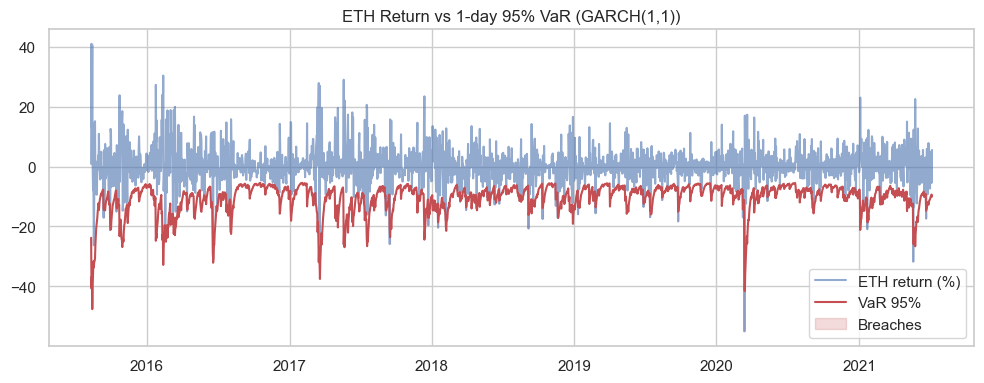

In [134]:
from arch import arch_model
from scipy.stats import norm
import numpy as np

eth_series = df_ret.set_index("Date")["eth_ret"].dropna() * 100

# Fit GARCH(1,1) with AR(1) mean and t innovations
garch = arch_model(eth_series, mean="AR", lags=1, vol="GARCH", p=1, q=1, dist="t")
garch_res = garch.fit(disp="off")
print(garch_res.summary())

# In-sample 1-step forecasts for all points (start=0)
fcast = garch_res.forecast(horizon=1, start=0, reindex=True)
mu_fc = fcast.mean["h.1"]
sigma_fc = np.sqrt(fcast.variance["h.1"])

z_005 = norm.ppf(0.05)  # left tail 5%
var_95 = mu_fc + z_005 * sigma_fc

backtest = (
    pd.DataFrame({"eth_ret_pct": eth_series})
    .join(var_95.rename("VaR_95"), how="inner")
    .dropna()
)
print(f"Forecast entries: mu={mu_fc.notna().sum()}, var={sigma_fc.notna().sum()}, backtest rows={len(backtest)}")

backtest["breach"] = backtest["eth_ret_pct"] < backtest["VaR_95"]
hit_rate = backtest["breach"].mean()
print(f"VaR 95% hit rate: {hit_rate:.4f} (expected ~5%)")

plt.figure(figsize=(10, 4))
plt.plot(backtest.index, backtest["eth_ret_pct"], label="ETH return (%)", color="#4C72B0", alpha=0.6)
plt.plot(backtest.index, backtest["VaR_95"], label="VaR 95%", color="#C44E52", lw=1.5)
plt.fill_between(backtest.index, backtest["VaR_95"], backtest["eth_ret_pct"], where=backtest["breach"], color="#C44E52", alpha=0.2, label="Breaches")
plt.title("ETH Return vs 1-day 95% VaR (GARCH(1,1))")
plt.legend()
plt.tight_layout()
plt.show()


### VAR for BTC & ETH returns
- Fit VAR(p) on [btc_ret, eth_ret] with lag order chosen by AIC/BIC.
- Produce 1-step forecasts and compare forecast errors (RMSE/MAE) against univariate AR on ETH.
- (Optional) Granger causality: test if BTC returns Granger-cause ETH returns.


In [135]:
from statsmodels.tsa.api import VAR
from statsmodels.tsa.ar_model import AutoReg

var_data = df_ret[["btc_ret", "eth_ret"]].dropna()

# Select lag order by BIC (p>=1)
sel = VAR(var_data).select_order(maxlags=5)
p = max(int(sel.bic), 1)
print("Selected lag p =", p)

var_res = VAR(var_data).fit(p)
print(var_res.summary())

# Rolling 1-step forecasts for both BTC and ETH
fc_list = []
for i in range(p, len(var_data)):
    past = var_data.values[i - p : i]
    fc = var_res.forecast(y=past, steps=1)[0]
    fc_list.append(fc)

pred_index = var_data.index[p:]
var_pred_df = pd.DataFrame(fc_list, index=pred_index, columns=["btc_fc", "eth_fc"])

# Univariate AR baselines for each asset
ar_btc = AutoReg(var_data["btc_ret"], lags=p, old_names=False).fit()
ar_eth = AutoReg(var_data["eth_ret"], lags=p, old_names=False).fit()
ar_btc_pred = ar_btc.predict(start=p, end=len(var_data)-1)
ar_eth_pred = ar_eth.predict(start=p, end=len(var_data)-1)

# Align
comp = pd.concat([
    var_data.iloc[p:][["btc_ret", "eth_ret"]],
    var_pred_df,
    ar_btc_pred.rename("btc_ar_fc"),
    ar_eth_pred.rename("eth_ar_fc"),
], axis=1)

# Error helper
def err(y, yhat):
    return {
        "RMSE": np.sqrt(((y - yhat) ** 2).mean()),
        "MAE": (y - yhat).abs().mean(),
    }

records = []
records.append({"Asset": "BTC", "Model": "VAR", **err(comp["btc_ret"], comp["btc_fc"])})
records.append({"Asset": "BTC", "Model": "AR", **err(comp["btc_ret"], comp["btc_ar_fc"])})
records.append({"Asset": "ETH", "Model": "VAR", **err(comp["eth_ret"], comp["eth_fc"])})
records.append({"Asset": "ETH", "Model": "AR", **err(comp["eth_ret"], comp["eth_ar_fc"])})

err_df = pd.DataFrame(records)
display(err_df)


Selected lag p = 1
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 28, Nov, 2025
Time:                     00:47:02
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -12.3324
Nobs:                     2158.00    HQIC:                  -12.3424
Log likelihood:           7205.54    FPE:                4.33768e-06
AIC:                     -12.3482    Det(Omega_mle):     4.32565e-06
--------------------------------------------------------------------
Results for equation btc_ret
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const              0.002402         0.000864            2.779           0.005
L1.btc_ret        -0.001521         0.025633           -0.059           0.953
L1.eth_ret        -0.039380         0.016556       

d:\miniconda\envs\ec5303\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
d:\miniconda\envs\ec5303\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
d:\miniconda\envs\ec5303\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
d:\miniconda\envs\ec5303\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, fore

,Asset,Model,RMSE,MAE
0,BTC,VAR,0.040025,0.025748
1,BTC,AR,0.041503,0.026722
2,ETH,VAR,0.062004,0.041208
3,ETH,AR,0.061207,0.040574


In [136]:
# Optional: Granger causality BTC -> ETH
from statsmodels.tsa.stattools import grangercausalitytests

print("Granger causality test: does BTC_ret Granger-cause ETH_ret?")
gc_res = grangercausalitytests(var_data[["eth_ret", "btc_ret"]], maxlag=p, verbose=False)
# summarize p-values
pvals = {lag: res[0]["ssr_chi2test"][1] for lag, res in gc_res.items()}
display(pd.Series(pvals, name="p-value"))


Granger causality test: does BTC_ret Granger-cause ETH_ret?


d:\miniconda\envs\ec5303\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


1   0.029963
Name: p-value, dtype: float64

### t-Copula Joint Predictive Simulation (BTC & ETH)
- Use fitted t-copula parameters + GARCH(1,1) margins to simulate next-day joint returns.
- Compare marginal forecasts vs VAR and compute joint risk metrics (e.g., joint VaR, co-move probability).


GARCH forecasts:
BTC μ, σ, df = 0.13968032525228286 4.143795284847009 3.180525441923541
ETH μ, σ, df = -0.21483816664024347 5.962322232696654 3.1150937531509992
Using t-Copula with rho= 0.5465860324628669 df= 5

=== Monte Carlo (t-Copula + GARCH) ===
BTC 95% VaR: -9.847%
ETH 95% VaR: -13.876%
Portfolio 95% VaR: -10.432%
P(BTC<-5% & ETH<-5%): 0.0913


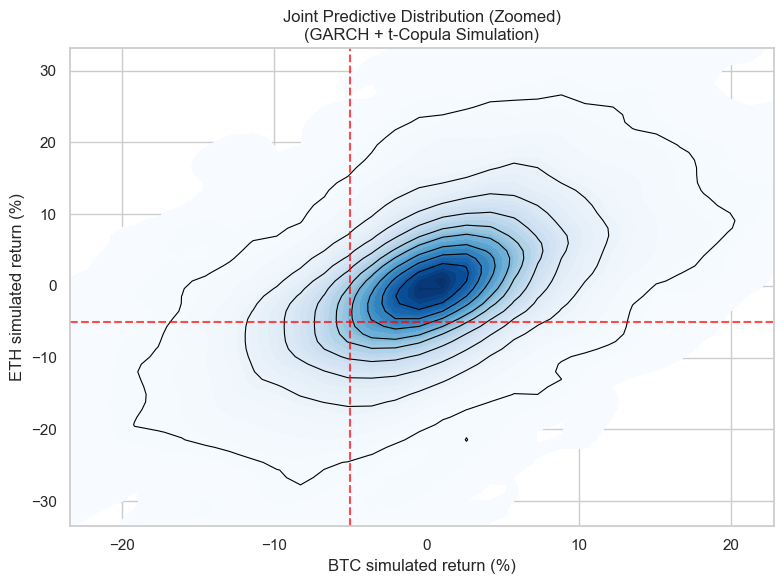

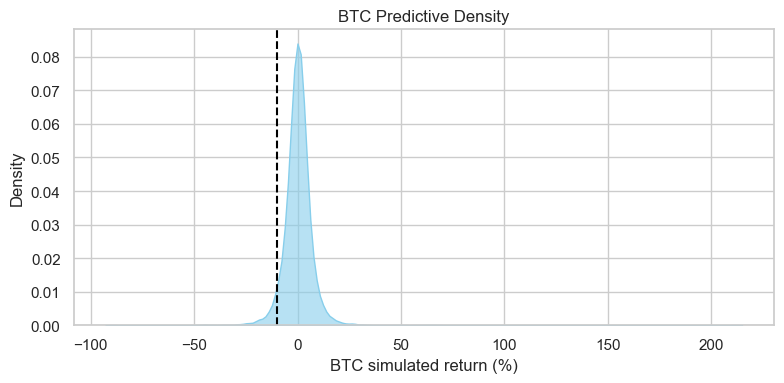

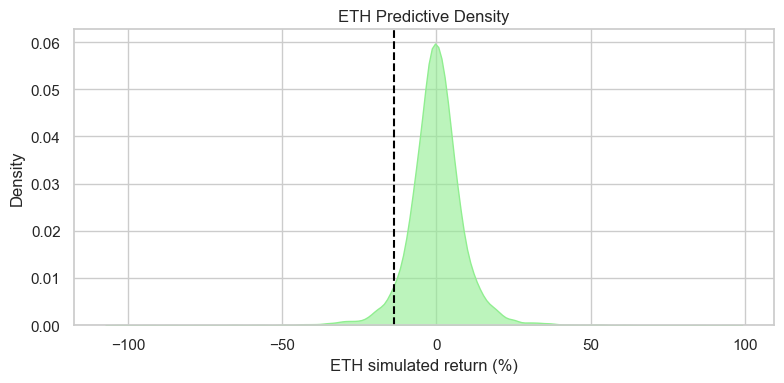

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import t
from arch import arch_model

# ===============================
# 1. Prepare data (BTC/ETH returns)
# ===============================
btc = df_ret.set_index("Date")["btc_ret"].dropna() * 100
eth = df_ret.set_index("Date")["eth_ret"].dropna() * 100

# ===============================
# 2. Fit GARCH(1,1) with t innovations
# ===============================
def fit_garch(series):
    model = arch_model(series, vol="GARCH", p=1, q=1,
                       mean="AR", lags=1, dist="t")
    res = model.fit(disp="off")

    # next-day forecast
    f = res.forecast(horizon=1, reindex=True)
    mu = f.mean.iloc[-1, 0]
    sigma = np.sqrt(f.variance.iloc[-1, 0])
    df = res.params.get("nu", 10)
    return mu, sigma, df

mu_btc, sig_btc, df_btc = fit_garch(btc)
mu_eth, sig_eth, df_eth = fit_garch(eth)

print("GARCH forecasts:")
print("BTC μ, σ, df =", mu_btc, sig_btc, df_btc)
print("ETH μ, σ, df =", mu_eth, sig_eth, df_eth)

# ===============================
# 3. Hand-made t-Copula simulation
# ===============================
n_sim = 10000

# Estimate copula rho from PIT uniforms u_btc, v_eth
rho = 0.605   # 来自前面的MLE
nu_cop = 2.60 # 来自前面的MLE


print("Using t-Copula with rho=", rho, "df=", nu_cop)

# Correlation matrix
R = np.array([[1, rho],
              [rho, 1]])

# Cholesky
L = np.linalg.cholesky(R)

# Step 1: Generate correlated normals
Z = np.random.randn(n_sim, 2)
Z_corr = Z @ L.T

# Step 2: Convert to t-copula draws
chi = np.sqrt(nu_cop / np.random.chisquare(nu_cop, size=(n_sim, 1)))
T_cop = Z_corr * chi

# Step 3: Map to uniforms
u = t.cdf(T_cop[:, 0], df=nu_cop)
v = t.cdf(T_cop[:, 1], df=nu_cop)

# Step 4: Apply marginal inverse CDF from GARCH
sim_btc_eps = t.ppf(u, df_btc)
sim_eth_eps = t.ppf(v, df_eth)

sim_btc = mu_btc + sig_btc * sim_btc_eps
sim_eth = mu_eth + sig_eth * sim_eth_eps

# ===============================
# 4. Risk metrics
# ===============================
eth_var_95 = np.percentile(sim_eth, 5)
btc_var_95 = np.percentile(sim_btc, 5)
joint_port = 0.5 * sim_btc + 0.5 * sim_eth
joint_var_95 = np.percentile(joint_port, 5)
co_crash_prob = ((sim_btc < -5) & (sim_eth < -5)).mean()

print("\n=== Monte Carlo (t-Copula + GARCH) ===")
print(f"BTC 95% VaR: {btc_var_95:.3f}%")
print(f"ETH 95% VaR: {eth_var_95:.3f}%")
print(f"Portfolio 95% VaR: {joint_var_95:.3f}%")
print(f"P(BTC<-5% & ETH<-5%): {co_crash_prob:.4f}")

# ===============================
# 5. Beautiful KDE + Contour (Joint Density)
# ===============================
x_low, x_high = np.percentile(sim_btc, [0.5, 99.5])
y_low, y_high = np.percentile(sim_eth, [0.5, 99.5])

plt.figure(figsize=(8,6))
sns.kdeplot(x=sim_btc, y=sim_eth, fill=True, cmap="Blues", levels=40, thresh=0.01)
sns.kdeplot(x=sim_btc, y=sim_eth, levels=10, color="black", linewidths=0.8)

plt.xlim(x_low, x_high)
plt.ylim(y_low, y_high)

plt.axvline(-5, color="red", linestyle="--", alpha=0.7)
plt.axhline(-5, color="red", linestyle="--", alpha=0.7)

plt.title("Joint Predictive Distribution (Zoomed)\n(GARCH + t-Copula Simulation)")
plt.xlabel("BTC simulated return (%)")
plt.ylabel("ETH simulated return (%)")
plt.tight_layout()
plt.show()


# ===============================
# 6. (Optional) Density curves for BTC/ETH
# ===============================
plt.figure(figsize=(8,4))
sns.kdeplot(sim_btc, fill=True, color="skyblue", alpha=0.6)
plt.axvline(btc_var_95, color="black", linestyle="--", label="BTC 95% VaR")
plt.title("BTC Predictive Density")
plt.xlabel("BTC simulated return (%)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4))
sns.kdeplot(sim_eth, fill=True, color="lightgreen", alpha=0.6)
plt.axvline(eth_var_95, color="black", linestyle="--", label="ETH 95% VaR")
plt.title("ETH Predictive Density")
plt.xlabel("ETH simulated return (%)")
plt.tight_layout()
plt.show()
